## O que faremos:

1 Examinar os dados

2 Pré-processar dos dados

3 Construir diversos modelos e compará-los

## Construindo um modelo para prever o AVC

Segundo a Organização Mundial da Saúde (OMS), o AVC é a 2ª causa de morte no mundo, sendo responsável por aproximadamente 11% do total de óbitos.

Esse conjunto de dados é usado para prever a probabilidade de um paciente ter um AVC com base em parâmetros de entrada, como sexo, idade, várias condições médicas e tabagismo. Cada amostra dos dados contém informações relevantes do paciente.

O objetivo do projeto é criar um modelo para prever o AVC.


Alguns passos importantes para projetos aplicados:
1. Estudar os dados iniciais.
2. Efetuar possíveus pré-processamento de dados.
3. Cálculo de informações/características adicionais.
4. Explore os dados.
5. Construa um modelo (neste caso, usando regressão logística).
6. Avalie o modelo sob métricas relevantes.

## Examinando os dados...

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
data = pd.read_csv('./archive/healthcare-dataset-stroke-data.csv')
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,nan,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
5,56669,Male,81.00,0,0,Yes,Private,Urban,186.21,29.00,formerly smoked,1
6,53882,Male,74.00,1,1,Yes,Private,Rural,70.09,27.40,never smoked,1
7,10434,Female,69.00,0,0,No,Private,Urban,94.39,22.80,never smoked,1
8,27419,Female,59.00,0,0,Yes,Private,Rural,76.15,nan,Unknown,1
9,60491,Female,78.00,0,0,Yes,Private,Urban,58.57,24.20,Unknown,1


Informações gerais sobre o dataset...

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Portanto, a tabela tem 12 colunas. <br>
De acordo com a documentação de dados: <br>
1) id: unique identifier<br>
2) gender: "Male", "Female" or "Other"<br>
3) age: age of the patient<br>
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension<br>
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease<br>
6) ever_married: "No" or "Yes"<br>
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"<br>
8) Residence_type: "Rural" or "Urban"<br>
9) avg_glucose_level: average glucose level in blood<br>
10) bmi: body mass index<br>
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*<br>
12) stroke: 1 if the patient had a stroke or 0 if not<br>

*Notar: "Unknown" em ``smoking_status`` significa que aquela informação não está disponível para aquele paciente.

## Pré-processamento de dados...

In [5]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,"5,110.00","5,110.00","5,110.00","5,110.00","5,110.00","4,909.00","5,110.00"
mean,"36,517.83",43.23,0.10,0.05,106.15,28.89,0.05
std,"21,161.72",22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,"17,741.25",25.00,0.00,0.00,77.25,23.50,0.00
50%,"36,932.00",45.00,0.00,0.00,91.88,28.10,0.00
75%,"54,682.00",61.00,0.00,0.00,114.09,33.10,0.00
max,"72,940.00",82.00,1.00,1.00,271.74,97.60,1.00


Vamos construir um mapa de calor (heatmap) para determinar quais parâmetros estão relacionados entre si (correlação). 

Como a presença de correlação entre os parâmetros pode levar à deterioração da qualidade do modelo construído, tais parâmetros devem ser excluídos.

<AxesSubplot:>

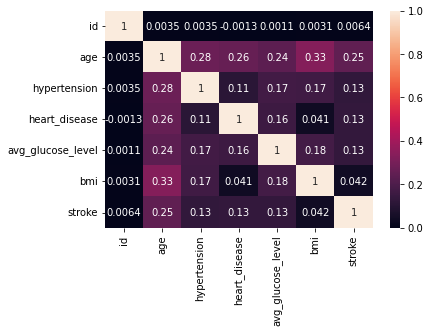

In [6]:
sns.heatmap(data.corr(), annot = True)

De acordo com o mapa de calor obtido, vemos que a relação entre os parâmetros estudados é fraca (o maior valor é 0.33).

Agora, precisamos codificar os valores das variáveis categóricas para construir um modelo que recebe dados numéricos...

In [7]:
# Conta o número de elementos distindos em um eixo especificado.
# Retorna uma série com o número de elementos distintos.
data_uniques = data.nunique()
print(data_uniques)

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64


In [8]:
# Cria uma lista com as variáveis binárias
binary_vals = list(data_uniques[data_uniques == 2].index) 
print(binary_vals)

['hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke']


In [9]:
# Quais dados são categóricos e quais numéricos?
data[binary_vals].dtypes 

hypertension       int64
heart_disease      int64
ever_married      object
Residence_type    object
stroke             int64
dtype: object

In [10]:
# Determinaremos as variáveis categóricas
categorical_vals  = list(data_uniques[(data_uniques > 2) & (data_uniques <=6)].index)
print(categorical_vals)

['gender', 'work_type', 'smoking_status']


In [11]:
# Iteramos sobre todas as variáveis categóricas, ordenando-as, e então aplicamos o processo de "encode"
#[[i, list(data[i].unique())] for i in categorical_vals] 

In [12]:
# Extendemos as variaveis numericas sobre todo o dataset e variáveis binarias
numeric_vals = list(set(data.columns) - set(categorical_vals)- set(binary_vals))
print(numeric_vals)

['bmi', 'avg_glucose_level', 'id', 'age']


**O processo de ``Encoding``:**

In [13]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

**LabelBinarizer:** converte valores naturalmente binários (Yes, No, True, False) em (0 & 1).

**LabelEncoder:** usado para transformar classes não numéricas desde que possível.

**OrdinalEncoder:** cada valor em uma dada categoria assume um valor inteiro. Por exemplo, "vermelho" é 1, "azul" é 2, e etc.

In [14]:
lb, le, lo = LabelBinarizer(), LabelEncoder(), OrdinalEncoder()

In [15]:
for col in categorical_vals: 
    data[col] = le.fit_transform(data[col])
    
for col in binary_vals:
    data[col] = lb.fit_transform(data[col])

In [16]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.00,0,1,1,2,1,228.69,36.60,1,1
1,51676,0,61.00,0,0,1,3,0,202.21,nan,2,1
2,31112,1,80.00,0,1,1,2,0,105.92,32.50,2,1
3,60182,0,49.00,0,0,1,2,1,171.23,34.40,3,1
4,1665,0,79.00,1,0,1,3,0,174.12,24.00,2,1


In [17]:
#data.stroke.value_counts() 


In [18]:
#data = pd.get_dummies(data, columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 
#                                       'smoking_status'])

Verificamos também se no conjunto de dados há duplicatas.

In [19]:
data.duplicated().sum()

0

Vamos ver quais parâmetros têm valores ausentes ou não numéricos (``NaN``).

In [20]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [21]:
data.isna().mean()

id                  0.00
gender              0.00
age                 0.00
hypertension        0.00
heart_disease       0.00
ever_married        0.00
work_type           0.00
Residence_type      0.00
avg_glucose_level   0.00
bmi                 0.04
smoking_status      0.00
stroke              0.00
dtype: float64

Existem lacunas nos dados na coluna ``bmi``, a porcentagem de valores ausentes é de cerca de 4%. Para preencher com mais precisão os valores ausentes, usaremos o algoritmo de regressão linear.

Criaremos uma coluna no conjunto de dados que indicará se há um valor ausente.

In [22]:
data['pass'] = data.bmi.isna()

Além disso, as linhas em que não houverem valores ausentes serão usadas para treinar o modelo.

In [23]:
train = data.loc[data['pass'] == False]
x_train = train.drop(['pass', 'bmi', 'stroke', 'id'], axis = 1)
y_train = train.bmi
target = data.loc[data['pass'] == True]
x_target = target.drop(['pass', 'bmi', 'stroke', 'id'], axis = 1)

Vamos construir um modelo de regressão linear para preencher os valores ausentes.

In [24]:
from sklearn.linear_model import LinearRegression 

regressor = LinearRegression() 
regressor.fit(x_train, y_train)

result = regressor.predict(x_target)
y_pred = pd.Series(result)

In [25]:
y_pred = np.array(y_pred)

In [26]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
pass                   0
dtype: int64

In [27]:
target.loc[:, 'bmi'] = y_pred

/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Vamos coletar o conjunto de dados recebido sem lacunas.

In [28]:
df = train.append(target, ignore_index=True) 

In [29]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
pass                 0
dtype: int64

Agora não há lacunas nos dados e podemos prosseguir para a criação do modelo completo. 

Vamos remover a coluna ``pass`` antes de fazer isso, pois essas informações não serão usadas para construir o modelo completo.

In [30]:
df=df.drop('pass', axis = 1)
df=df.drop('id', axis = 1)

In [31]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.00,0,1,1,2,1,228.69,36.60,1,1
1,1,80.00,0,1,1,2,0,105.92,32.50,2,1
2,0,49.00,0,0,1,2,1,171.23,34.40,3,1
3,0,79.00,1,0,1,3,0,174.12,24.00,2,1
4,1,81.00,0,0,1,2,1,186.21,29.00,1,1


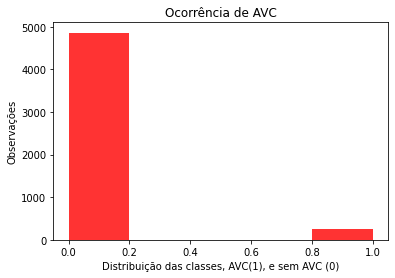

In [32]:
ax = plt.axes()
ax.hist(df.stroke, bins=5, alpha=0.8, color='red')
ax.set(xlabel='Distribuição das classes, AVC(1), e sem AVC (0)',
       ylabel='Observações',
       title='Ocorrência de AVC')
plt.show()

Classes totalmente desbalanceadas...

## Construindo os modelos...

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
# dividimos os dados iniciais em treinamento e teste
train, test = train_test_split(df, 
                               train_size=0.7, 
                               random_state=0)

X_train = train.drop('stroke', axis = 1)
y_train = train.stroke
X_test = test.drop('stroke', axis = 1)
y_test = test.stroke

In [35]:
scaler = StandardScaler() #MinMaxScaler()

x_train = scaler.fit_transform(X_train)

x_test = scaler.transform(X_test)

In [36]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)

In [37]:
result = model.predict(x_test)

In [38]:
param_grid = [
    { #parâmetros do modelo:
        'penalty' : ['l1', 'l2'],
        'C': (1, 5, 10, 15, 20),
        'max_iter' : (25, 100, 200),
        'solver' : ['liblinear']}
]

In [39]:
param_grid

[{'penalty': ['l1', 'l2'],
  'C': (1, 5, 10, 15, 20),
  'max_iter': (25, 100, 200),
  'solver': ['liblinear']}]

In [40]:
clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1)
best_clf_regression = clf.fit(x_train, y_train)
result_lr = best_clf_regression.predict(x_test)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


Podemos utilizar a curva ROC (temos um problema de classificação binária, ela pode ser interessante) para avaliarmos o modelo de regressão logística construído.

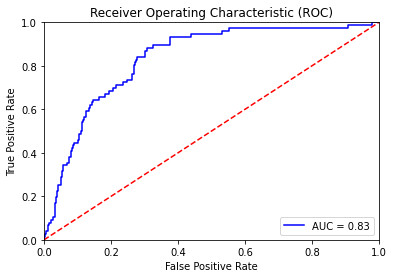

In [41]:
probs = model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Para comparação, vamos construir outra ROC para o modelo de regressão logística em que os parâmetros foram selecionados via ``grid search``.

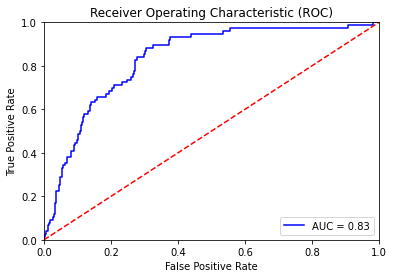

In [42]:
probs = best_clf_regression.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
print(confusion_matrix(y_test, np.array(result_lr, 'float16')))

[[1457    0]
 [  75    1]]


In [44]:
print(confusion_matrix(y_test, np.array(result, 'float16')))

[[1457    0]
 [  75    1]]


In [45]:
print(classification_report(y_test, result_lr))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1457
           1       1.00      0.01      0.03        76

    accuracy                           0.95      1533
   macro avg       0.98      0.51      0.50      1533
weighted avg       0.95      0.95      0.93      1533



De acordo com as curvas construídas, verificamos que a escolha dos parâmetros ótimos da regressão logística não permitiu aumentar a acurácia do modelo.

In [46]:
from sklearn.tree import DecisionTreeClassifier 

In [47]:
dt = DecisionTreeClassifier(random_state=42)

In [48]:
dt = dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

In [49]:
dt.tree_.node_count, dt.tree_.max_depth

(507, 17)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1457
           1       0.16      0.18      0.17        76

    accuracy                           0.91      1533
   macro avg       0.56      0.57      0.56      1533
weighted avg       0.92      0.91      0.91      1533



In [51]:
print(confusion_matrix(y_test, y_pred))

[[1383   74]
 [  62   14]]


O resultado isolado de uma DT foi razoável

Vamos seguir para a construção de um modelo usando uma Floresta Aleatória (Random Forest).

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
clf = RandomForestClassifier()

In [86]:
clf = clf.fit(x_train, y_train)

In [87]:
result_random_forest = clf.predict(x_test)

In [88]:
params = [ 
    {'n_estimators' : list(range(50,155,10)),
     'max_depth' : list(range(5,30,5)),
     'criterion': ['gini', 'entropy'],
     'min_samples_split': list(np.arange(2, 5))}
]

In [89]:
params

[{'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
  'max_depth': [5, 10, 15, 20, 25],
  'criterion': ['gini', 'entropy'],
  'min_samples_split': [2, 3, 4]}]

In [90]:
from sklearn.model_selection import GridSearchCV

In [91]:
clf1 = GridSearchCV(RandomForestClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1)

In [92]:
best_clf_forest = clf1.fit(x_train, y_train)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


In [93]:
result_forest = best_clf_forest.predict(x_test)

Vamos construir uma ROC para o modelo de floresta aleatória resultante.

Construímos uma característica para o modelo original e levando em consideração a escolha dos parâmetros ótimos, outra.

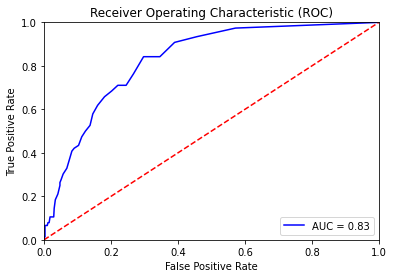

In [63]:
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

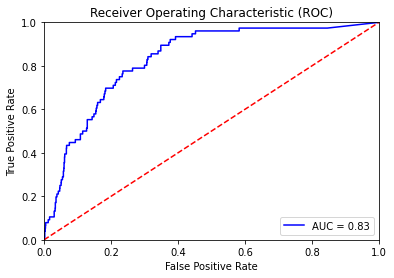

In [64]:
probs = best_clf_forest.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Como resultado do trabalho, o ``GridSearchCV`` conseguiu aumentar a AUC de 0, para 0,.

O modelo resultante construído usando o algoritmo acabou sendo mais preciso do que o modelo de regressão logística resultante.

In [94]:
confusion_matrix(y_test, np.array(result_forest, 'float16'))

array([[1456,    1],
       [  75,    1]])

In [66]:
confusion_matrix(y_test, np.array(result_random_forest, 'float16'))

array([[1455,    2],
       [  75,    1]])

In [67]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
knn = KNeighborsClassifier(n_neighbors=5)

In [69]:
knn = knn.fit(x_train, y_train)

In [70]:
y_pred = knn.predict(x_test)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1457
           1       0.20      0.01      0.02        76

    accuracy                           0.95      1533
   macro avg       0.58      0.51      0.50      1533
weighted avg       0.91      0.95      0.93      1533



## The MAIN question...

Como resolvemos o overfitting?